In [31]:
import pandas as pd
import numpy as np
import os
from roboflow import Roboflow
import seaborn as sns
import cv2
import matplotlib.pyplot as plt

from scripts.visualization import visualize_batch_on_grid, plot_class_distribution
from scripts.utils import get_class_distribution
from scripts.augmentations import augment_image
from scripts.compare_models import plot_metric

**Collect the data**

In [8]:
if os.path.isdir('datasets'):
    print("Dataset already downloaded")
else:
    rf = Roboflow(api_key="91wRcVQaXn0dpCrfb6Y8")
    project = rf.workspace("roboflow-100").project("construction-safety-gsnvb")
    version = project.version(1)
    dataset = version.download("yolov8")



Dataset already downloaded


In [12]:
# rename folder to datasets

if os.path.isdir('construction-safety-1'): os.rename("../PPE_Detection/construction-safety-1", "../PPE_Detection/datasets")
path = ("../PPE_Detection/datasets")

# # check if the path exists
if not os.path.exists(path):
    print("Path does not exist")

# check what is in the path
print('Data downloaded:')
print(os.listdir(path))

DATASET_PATH = path
IMAGES_DIR = os.path.join(DATASET_PATH, "train/images")
LABELS_DIR = os.path.join(DATASET_PATH, "train/labels")

print(f"Images: {len(os.listdir(IMAGES_DIR))}")
print(f"Labels: {len(os.listdir(LABELS_DIR))}")

Data downloaded:
['augmented_train', 'data.yaml', 'README.dataset.txt', 'README.roboflow.txt', 'test', 'train', 'valid']
Images: 997
Labels: 997


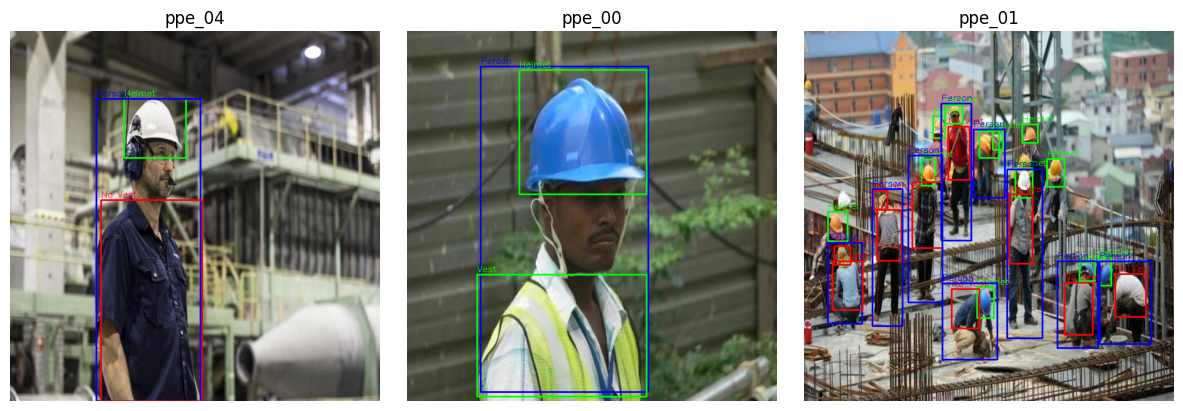

In [14]:

# Example usage
visualize_batch_on_grid(DATASET_PATH, split='train', num_images=3)



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



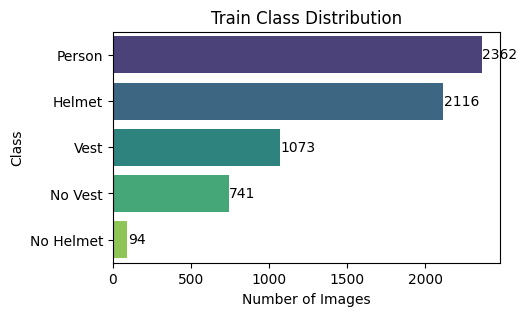

In [16]:
from scripts.visualization import CLASS_MAP  # if needed
train_dist = get_class_distribution(DATASET_PATH, split='train')
plot_class_distribution(train_dist, "Train Class Distribution")

"No Vest" and "No Helmet" classes are underrepresented. Data augmentation is needed.
I will create sepearte folders for the augmented data.

In [9]:
AUG_IMAGES_DIR = os.path.join(DATASET_PATH, 'augmented_train/images')
AUG_LABELS_DIR = os.path.join(DATASET_PATH, 'augmented_train/labels')
os.makedirs(AUG_IMAGES_DIR, exist_ok=True)
os.makedirs(AUG_LABELS_DIR, exist_ok=True)

In [11]:
for img_name in os.listdir(IMAGES_DIR):
    img_path = os.path.join(IMAGES_DIR, img_name)
    label_path = os.path.join(LABELS_DIR, img_name.replace(".jpg", ".txt").replace(".png", ".txt"))

    if os.path.exists(label_path):
        augment_image(img_path, label_path, AUG_IMAGES_DIR, AUG_LABELS_DIR)

print("Augmentation complete")

Augmentation complete




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



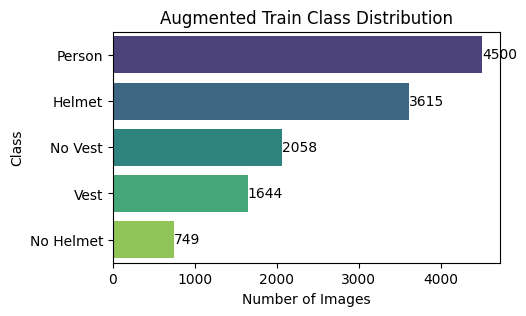

In [20]:
aug_train_class_distribution = get_class_distribution(split='augmented_train', DATASET_PATH=DATASET_PATH)
plot_class_distribution(aug_train_class_distribution, "Augmented Train Class Distribution")


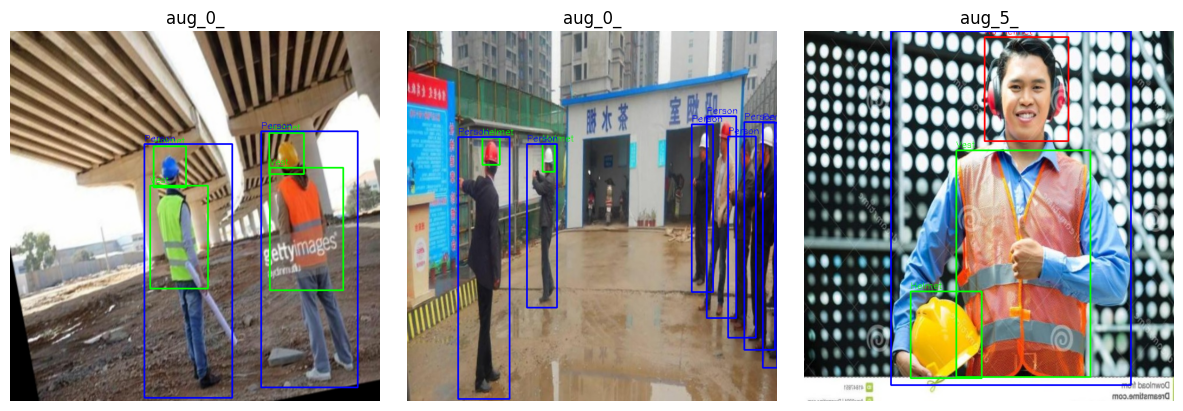

In [22]:
visualize_batch_on_grid(split='augmented_train', num_images=3, DATASET_PATH=DATASET_PATH)

Model Training

In [8]:
from ultralytics import YOLO
model = YOLO("yolov8s.pt")

In [ ]:
model.tune(
    data='datasets/data.yaml',
    imgsz=640,
    epochs=15,
    iterations=50,  # Number of tuning iterations
    batch=16,
    mosaic=0.3,
    mixup=0.2,
    project='model_trains',
    name='50_evolves'
)

After running the automatic hyperparameter tuning on the 15 epochs and 50 iterations, I have found the best parameters.
It is immportant to note that these hyperparameters were evluated on 15 epoch only due to the computational limitations I have.
The actual training would require a higher number of epochs.   

In [2]:
import yaml

with open('model_trains/50_evolves/best_hyperparameters.yaml', 'r') as f:
    best_hyp = yaml.safe_load(f)

print(best_hyp)

{'lr0': 0.00986, 'lrf': 0.01159, 'momentum': 0.89283, 'weight_decay': 0.00056, 'warmup_epochs': 2.25939, 'warmup_momentum': 0.7903, 'box': 7.17805, 'cls': 0.51853, 'dfl': 1.67123, 'hsv_h': 0.01591, 'hsv_s': 0.70091, 'hsv_v': 0.42543, 'degrees': 0.0, 'translate': 0.10617, 'scale': 0.49925, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.6201, 'bgr': 0.0, 'mosaic': 0.24429, 'mixup': 0.18807, 'copy_paste': 0.0}


In [ ]:
model1 = YOLO("yolov8s.pt")

In [ ]:
# get the best weights and thain the model
model1.train(
    data='datasets/data.yaml',
    epochs=80,              
    imgsz=640,
    batch=16,
    project='full_model_2',
    name='trained_with_best_hyp',
    verbose=True,
    save=True,
    save_period=10,
    **best_hyp                
)


In [7]:
# Read the results
import pandas as pd
results = pd.read_csv('full_model_2/trained_with_best_hyp/results.csv')
results.head()

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,16.8572,1.51475,1.91794,1.78460,0.73722,0.50769,0.55687,0.28787,1.51839,1.40589,1.86756,0.000485,0.000485,0.000485
1,2,30.1702,1.47037,1.38771,1.70323,0.56587,0.48245,0.53646,0.25360,1.55695,1.90455,1.93380,0.000966,0.000966,0.000966
2,3,43.1700,1.48845,1.33202,1.72537,0.64541,0.53227,0.62949,0.29031,1.62628,1.34990,1.96374,0.001084,0.001084,0.001084
3,4,56.1341,1.48520,1.28996,1.72000,0.76044,0.51271,0.61905,0.31265,1.54305,1.27016,1.88547,0.001070,0.001070,0.001070
4,5,69.1710,1.47559,1.28775,1.72585,0.76292,0.59385,0.72628,0.38078,1.43185,1.09359,1.82699,0.001056,0.001056,0.001056


In [ ]:
model_2 = YOLO('yolov8s.pt')

model_2.train(
    data='datasets/data.yaml',
    epochs=50,
    patience=10,  # Early stopping after 10 epochs without improvement
    imgsz=640,
    batch=16,
    mosaic=0.5,
    mixup=0.3,
    copy_paste=0.1,
    project='full_model_2',
    name='augmentation_earlystop_run'
)


In [ ]:
model_3 = YOLO('yolov8m.pt')

model_3.train(
    data='datasets/data.yaml',
    epochs=50,
    patience=10,  
    imgsz=640,
    batch=16,
    mosaic=0.5,
    mixup=0.3,
    copy_paste=0.1,
    project='full_model_2',
    name='medium_model_earlystop_run'
)


In [ ]:
model_4 = YOLO('yolov8s.pt')

model_4.train(
    data='datasets/data.yaml',
    epochs=50,
    patience=10,  
    imgsz=800,
    batch=16,
    mosaic=0.5,
    mixup=0.3,
    copy_paste=0.1,
    augment=True,
    project='full_model_2',
    name='small_imgSize_testAug'
)


In [ ]:
class_weights = {0: 1.0, 1: 2, 2: 2, 3: 1.0, 4: 1.0}


model5 = YOLO('yolov8s.pt')

model5.train(
    data='datasets/data.yaml',
    epochs=100,
    patience=20,
    imgsz=640,
    batch=16,
    mosaic=0.5,
    mixup=0.3,
    copy_paste=0.1,
    multi_scale=True,
    project='full_model_2',
    name='class_weighted_multiscale',
    # class_weights={0: 1.0, 1: 2.0, 2: 2.0, 3: 1.0, 4: 1.0}  # Add this if supported in your version
)


In [ ]:
model = YOLO('full_model_2/class_weighted_multiscale/weights/last.pt')

model.train(
    resume=True
)


In [7]:
model_names = [
    'trained_with_best_hyp',
    'augmentation_earlystop_run',
    'medium_model_earlystop_run2',
    'small_imgSize_testAug',
    'class_weighted_multiscale',
]

for name in model_names:
    model = YOLO(f'full_model_2/{name}/weights/best.pt')
    print(f"\nEvaluating {name}")
    metrics = model.val(data='datasets/data.yaml', split='test', imgsz=640)


Evaluating trained_with_best_hyp
Ultralytics 8.3.92  Python-3.12.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning D:\Coding\Projects 2\NNProjects\NeuralNetworkProjects\PPE_Detection\datasets\test\labels.cache... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


                   all         90        623      0.795      0.757      0.783      0.421
                helmet         82        195       0.88      0.913      0.934      0.517
             no-helmet         11         24      0.739      0.542       0.56      0.207
               no-vest         31         61        0.7      0.652      0.672      0.297
                person         88        214      0.847      0.893      0.893      0.596
                  vest         57        129      0.808      0.785      0.857       0.49
Speed: 2.2ms preprocess, 8.6ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to runs\detect\val

Evaluating augmentation_earlystop_run
Ultralytics 8.3.92  Python-3.12.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning D:\Coding\Projects 2\NNProjects\NeuralNetworkProjects\PPE_Detection\datasets\test\labels.cache... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.09it/s]


                   all         90        623      0.803      0.793      0.807      0.438
                helmet         82        195      0.866      0.908      0.926      0.519
             no-helmet         11         24      0.828      0.601      0.646      0.275
               no-vest         31         61       0.71      0.738      0.693      0.312
                person         88        214      0.774      0.897      0.896      0.591
                  vest         57        129      0.839      0.822      0.875      0.494
Speed: 1.6ms preprocess, 8.9ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to runs\detect\val2

Evaluating medium_model_earlystop_run2
Ultralytics 8.3.92  Python-3.12.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
Model summary (fused): 92 layers, 25,842,655 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning D:\Coding\Projects 2\NNProjects\NeuralNetworkProjects\PPE_Detection\datasets\test\labels.cache... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


                   all         90        623      0.789      0.784      0.801      0.422
                helmet         82        195      0.842      0.882      0.915      0.511
             no-helmet         11         24      0.779      0.542       0.63      0.243
               no-vest         31         61      0.645      0.774      0.714      0.285
                person         88        214      0.826      0.907      0.893      0.579
                  vest         57        129      0.854      0.816      0.854      0.491
Speed: 1.3ms preprocess, 14.9ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\val3

Evaluating small_imgSize_testAug
Ultralytics 8.3.92  Python-3.12.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning D:\Coding\Projects 2\NNProjects\NeuralNetworkProjects\PPE_Detection\datasets\test\labels.cache... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.09it/s]


                   all         90        623      0.779       0.81      0.803      0.434
                helmet         82        195      0.823      0.897      0.914      0.524
             no-helmet         11         24      0.731      0.625      0.658      0.251
               no-vest         31         61      0.679      0.754       0.67      0.307
                person         88        214      0.821      0.921       0.89      0.595
                  vest         57        129       0.84      0.853      0.884      0.491
Speed: 1.3ms preprocess, 7.3ms inference, 0.1ms loss, 5.1ms postprocess per image
Results saved to runs\detect\val4

Evaluating class_weighted_multiscale
Ultralytics 8.3.92  Python-3.12.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning D:\Coding\Projects 2\NNProjects\NeuralNetworkProjects\PPE_Detection\datasets\test\labels.cache... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]


                   all         90        623      0.768      0.753      0.784       0.42
                helmet         82        195      0.851       0.91      0.918      0.508
             no-helmet         11         24       0.73      0.564      0.623      0.262
               no-vest         31         61      0.579      0.689      0.634      0.275
                person         88        214      0.839      0.897      0.906        0.6
                  vest         57        129      0.842      0.703      0.839      0.457
Speed: 1.3ms preprocess, 7.3ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to runs\detect\val5


augmentation_earlystop_run showed the best performance.
It does have some problems with the "No helmet" and "No vest", which can be solved by enriching the dataset with more instances of these classes.
Artificial augmentations do not bring much value at this point.